## Textual analysis of the novels of Virginia Woolf

In [1]:
import requests
import os
import re
import string
from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
import stanza
import json
from nltk.corpus import wordnet as wn

stopword_list = stopwords.words('english')
stopword_list.extend(['s','mrs','mr','nt','h'])


def ptb_to_wordnet(PTT):

        if PTT.startswith('J'):
            ## Adjective
            return 'a'
        elif PTT.startswith('V'):
            ## Verb
            return 'v'
        elif PTT.startswith('N'):
            ## Noune
            return 'n'
        elif PTT.startswith('R'):
            ## Adverb
            return 'r'
        else:
            return ''

The novels are firstly downloaded from Project Gutenberg.

In [2]:
vw_urls = {
"https://gutenberg.net.au/ebooks02/0200211.txt":('Monday or Tuesday',39),
'https://gutenberg.net.au/ebooks02/0200991.txt':("Mrs. Dalloway",40),
'https://gutenberg.net.au/ebooks01/0100101.txt':("To the Lighthouse",40),
'https://gutenberg.net.au/ebooks02/0200331.txt':("Orlando",47),
'https://gutenberg.net.au/ebooks02/0201091.txt':("The Waves",40),
'https://gutenberg.net.au/ebooks03/0301171.txt':("Between the Acts",40),
'https://gutenberg.net.au/ebooks03/0301221.txt':("The Years",43),
'https://gutenberg.net.au/ebooks/m00020.txt':("The Voyage out",9),
'https://gutenberg.net.au/ebooks/m00019.txt':("Night and Day",9)
}

directory = 'Woolf'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
corpus = []
titles = dict()

for url in vw_urls:
    print(url)
    response = requests.get(url)
    if response:    
        file_name = vw_urls[url][0]
        file_name = re.sub(r'\s+','_',file_name)
        file_name = re.sub(r'[.]','',file_name)
        path = os.path.join(directory,f'{file_name.lower()}.txt')
        corpus.append(path)
        titles[path] = vw_urls[url][0]
        
        with open(path,'w',encoding='utf-8') as out:
            full_text = response.text.strip()
            full_text = re.sub(r'Project Gutenberg Australia$' , '', full_text)
            lines = re.split(r'\n' , response.text)
            full_text = '\n'.join(lines[vw_urls[url][1]:]).strip()
            out.write(full_text)
        print(f'"{vw_urls[url][0]}" has been downloaded ...')
    
    

https://gutenberg.net.au/ebooks02/0200211.txt
"Monday or Tuesday" has been downloaded ...
https://gutenberg.net.au/ebooks02/0200991.txt
"Mrs. Dalloway" has been downloaded ...
https://gutenberg.net.au/ebooks01/0100101.txt
"To the Lighthouse" has been downloaded ...
https://gutenberg.net.au/ebooks02/0200331.txt
"Orlando" has been downloaded ...
https://gutenberg.net.au/ebooks02/0201091.txt
"The Waves" has been downloaded ...
https://gutenberg.net.au/ebooks03/0301171.txt
"Between the Acts" has been downloaded ...
https://gutenberg.net.au/ebooks03/0301221.txt
"The Years" has been downloaded ...
https://gutenberg.net.au/ebooks/m00020.txt
"The Voyage out" has been downloaded ...
https://gutenberg.net.au/ebooks/m00019.txt
"Night and Day" has been downloaded ...


## Linguistic features

For each text, the number of characters, the number of words and the number of sentences are calculated. Using these data, we can compare the avarage word lengths and the average sentence lengths of all the novels. 

In [4]:
data = []

string.punctuation += '-•“”’– '

for file in corpus:
    print(f'Analysing {file} ... ')
    row = []
    text = open(file,encoding='utf-8')
    full_text = text.read()
    
    # Calculate number of characters (without spaces)
    full_text_no_spaces = re.sub( r'[{}]'.format(string.punctuation),'',full_text)
    nr_characters = len(full_text_no_spaces)
    
    # Calculate number of words
    words = word_tokenize(full_text.lower())
    words = [word for word in words if word not in string.punctuation]
    nr_tokens = len(words)
    
    avg_word_length = nr_characters / nr_tokens
    
    row.append(nr_tokens)
    row.append(avg_word_length)
    
    sentences = word_tokenize(full_text)
    nr_sentences = len(sentences)
    row.append(nr_sentences)
    
    row.append(nr_tokens/nr_sentences)
    
    first_2000 = words[:2000]
    unique = list(set(first_2000))
    ttr = len(unique)/len(first_2000)
    row.append(ttr)
    row.append(titles[file])

    data.append(row)
    
columns = ['nr_tokens','word_length','nr_sentences','words_per_sentence','ttr','title']
df = pd.DataFrame(data, columns = columns)

Analysing Woolf/monday_or_tuesday.txt ... 
Analysing Woolf/mrs_dalloway.txt ... 
Analysing Woolf/to_the_lighthouse.txt ... 
Analysing Woolf/orlando.txt ... 
Analysing Woolf/the_waves.txt ... 
Analysing Woolf/between_the_acts.txt ... 
Analysing Woolf/the_years.txt ... 
Analysing Woolf/the_voyage_out.txt ... 
Analysing Woolf/night_and_day.txt ... 


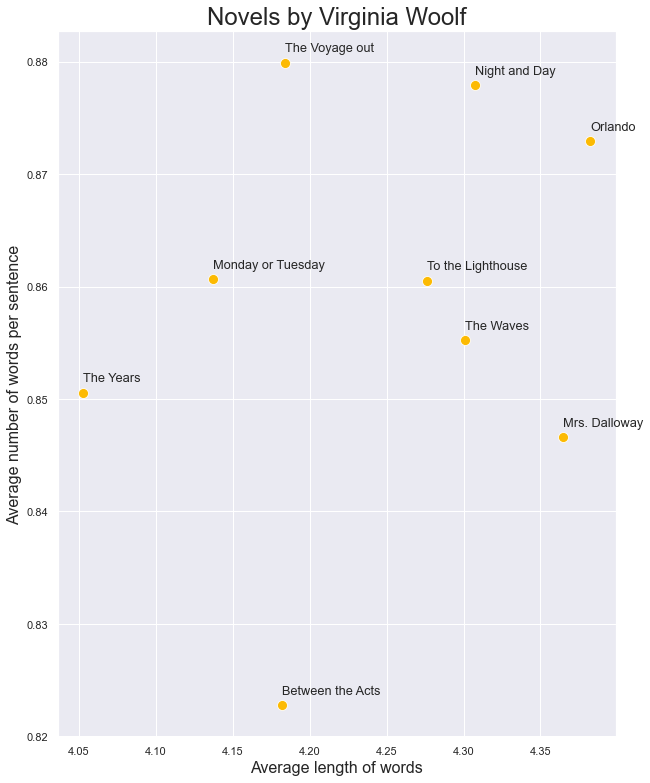

In [5]:
x_axis = 'word_length'
y_axis =  'words_per_sentence'
hue = 'category'
size = 'nr_tokens'

colours = ['#f9a65a','#599ad3']

fig = plt.figure( figsize = ( 10,13 ))

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df, x=x_axis, y=y_axis,  
                     color = '#fcba03',  s=100 )

for index, row in df.iterrows():
    plt.text( row[x_axis], row[y_axis]+ 0.001 , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Average length of words'  , fontsize = 16 )
ax.set_ylabel( 'Average number of words per sentence'  , fontsize = 16 )
ax.set_title( 'Novels by Virginia Woolf' , fontsize=24 )

plt.savefig( 'scatterplot.png' , dpi=300 )

The type-token ratio can be calculated by dividing the number of unique words (the types) by the total number of words (the tokens). The number gives [an indication of the lexical diversity](https://cdsleiden.github.io/tdm-tutorial/notebooks/5%20Type-token_ratio.html). 

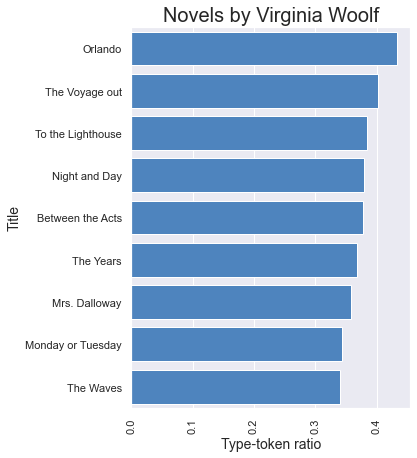

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

x_axis = 'ttr'
y_axis = 'title'

colours = ['#599ad3','#f9a65a']

fig = plt.figure( figsize=( 5,7 ) )

df_sorted = df.sort_values(by=[ x_axis] , ascending = False)

graph = sns.barplot( data=df_sorted , x=x_axis, y=y_axis, 
                    color = '#3b83d1' )

graph.set_title('Novels by Virginia Woolf' , size = 20) 
graph.set_xlabel('Type-token ratio' , size = 14) 
graph.set_ylabel('Title' , size = 14 )

plt.xticks(rotation= 90)


plt.show()

In [7]:
def clean_wordlist(words):
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stopword_list]
    #words = [word for word in words if len(word.strip())>2]
    words = [re.sub(r'([….])|(\')','',word) for word in words]
    words = [word for word in words if re.search(r'\w', word)]
    return words

## Part of Speech tagging and Lemmatisation

In [8]:
data = []
all_novels = []
lemmatiser = WordNetLemmatizer()

# Dictionaries to save all nouns, adjectives, adverbs and nouns 
all_adj_adv_noun = dict()
all_verbs = dict()

adj_noun_pos = ['JJ','JJR','RB','RDR','RBS','NN','NNS','NNP']
verbs_pos = ['VB','VBD','VBG','VBN']

# Dictionary to save number of tokens
nr_tokens = dict()

for file in corpus:
    lemmatised = ''
    pos_tags = dict()

    # Pos categories in the current text
    adj_adv_noun = []
    verbs = []
    
    count_tokens = 0
    
    out_file = re.sub( r'\.txt$' , '_lemma.txt', file)
    
    print(f'Analysing {file} ... ')

    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = clean_wordlist(words)
        pos = pos_tag(words)

        for i,word in enumerate(words):
            word = word.lower()

                
            pos_tags[pos[i][1]] = pos_tags.get(pos[i][1],0)+1
                       
            posTag = ptb_to_wordnet( pos[i][1] )
            if re.search( r'\w+' , posTag , re.IGNORECASE ):
                lemma = lemmatiser.lemmatize( words[i] , posTag )
                lemmatised += lemma + ' '
                count_tokens += 1
                
                if len(lemma)>0:
                
                    if pos[i][1] in adj_noun_pos:
                        adj_adv_noun.append(lemma.lower())
                    if pos[i][1] in verbs_pos:
                        verbs.append(lemma.lower())

        lemmatised += '\n'
    
    all_adj_adv_noun[file] = adj_adv_noun
    all_verbs[file] = verbs
    nr_tokens[file] = count_tokens
    all_novels.append(file)
        
    with open(out_file,'w',encoding='utf-8') as out:
        out.write(lemmatised)
        
    
    total = sum(pos_tags.values())
    row = []
    row.append(titles[file])
    row.append(pos_tags.get('MD',0)/total)
    row.append(pos_tags.get('FW',0)/total)
    row.append(pos_tags.get('JJ',0)/total)
    row.append((pos_tags.get('JJR',0)+pos_tags.get('JJS',0))/total)
    row.append(pos_tags.get('RB',0)/total)
    row.append((pos_tags.get('RBR',0)+pos_tags.get('RBS',0))/total)
    data.append(row)

df_pos = pd.DataFrame(data,columns=['title','modal_verb','foreign_word','adj','adj-comp-super','adv','adv-comp-super'])


Analysing Woolf/monday_or_tuesday.txt ... 
Analysing Woolf/mrs_dalloway.txt ... 
Analysing Woolf/to_the_lighthouse.txt ... 
Analysing Woolf/orlando.txt ... 
Analysing Woolf/the_waves.txt ... 
Analysing Woolf/between_the_acts.txt ... 
Analysing Woolf/the_years.txt ... 
Analysing Woolf/the_voyage_out.txt ... 
Analysing Woolf/night_and_day.txt ... 


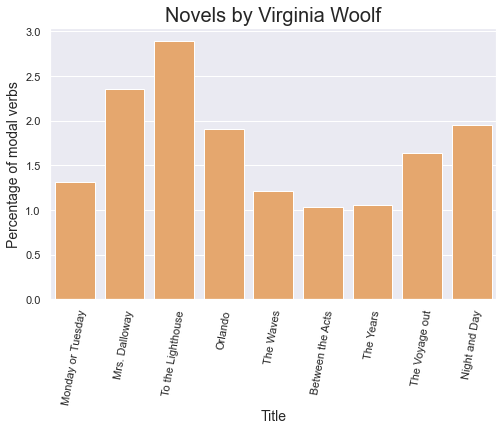

In [9]:

df_pos['modal_verb'] = df_pos['modal_verb']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='modal_verb', 
                    color = '#f9a65a' )

graph.set_title('Novels by Virginia Woolf' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of modal verbs' , size = 14 )

plt.xticks(rotation=80)

plt.show()

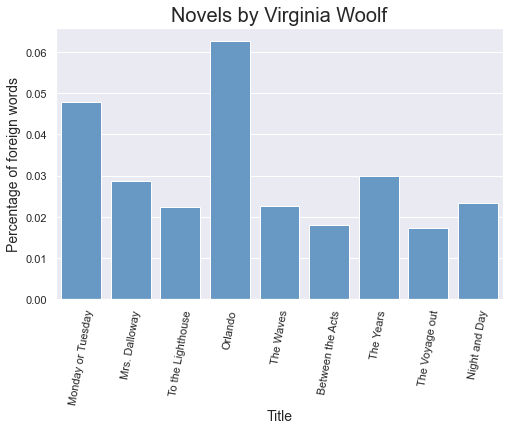

In [10]:
df_pos['foreign_word'] = df_pos['foreign_word']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='foreign_word', 
                    color = '#599ad3' )

graph.set_title('Novels by Virginia Woolf' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of foreign words' , size = 14 )

plt.xticks(rotation=80)

plt.show()

In [11]:
df_pos['adj-comp-super'] = df_pos['adj-comp-super']*100
df_pos['adj'] = df_pos['adj']*100
df_pos['adv-comp-super'] = df_pos['adv-comp-super']*100
df_pos['adv'] = df_pos['adv']*100

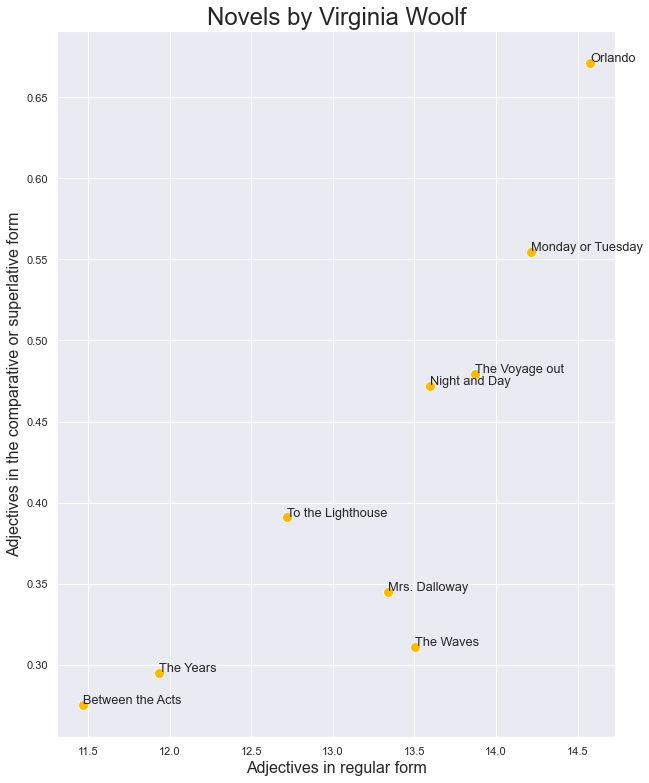

In [12]:
fig = plt.figure( figsize = ( 10,13 ))

x_axis='adj'
y_axis='adj-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     color = '#fcba03',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis]+ 0.001 , row['title'] , fontsize=12.8)

ax.set_xlabel( 'Adjectives in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adjectives in the comparative or superlative form'  , fontsize = 16 )
ax.set_title( 'Novels by Virginia Woolf' , fontsize=24 )

plt.show()

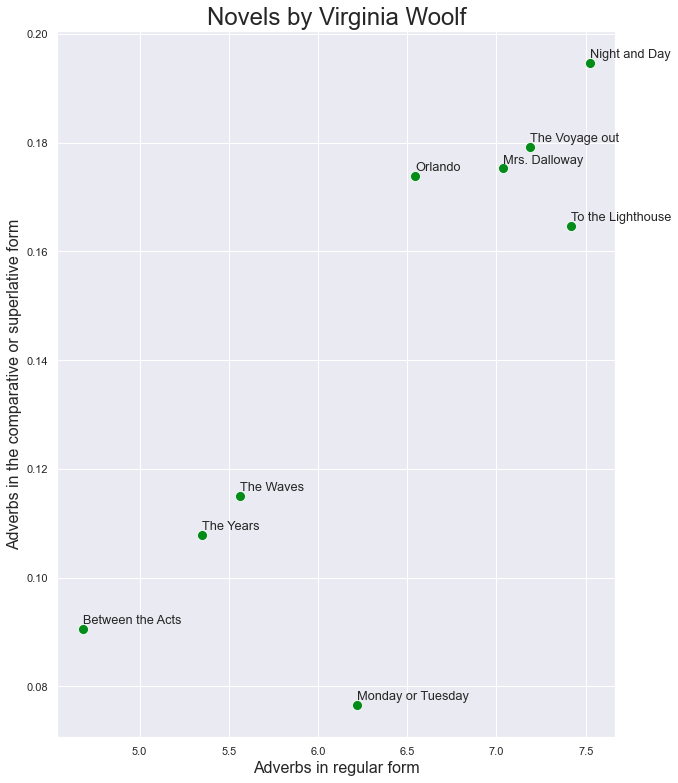

In [13]:
fig = plt.figure( figsize = ( 10,13 ))

x_axis='adv'
y_axis='adv-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     color = '#048c1b',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis]+ 0.001 , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Adverbs in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adverbs in the comparative or superlative form'  , fontsize = 16 )
ax.set_title( 'Novels by Virginia Woolf' , fontsize=24 )

plt.show()

# the 25 most frequent words in each novel

The words have been lemmatised first.

In [14]:
for file in os.listdir(directory):
    if re.search( 'lemma.txt',file ):
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            words = clean_wordlist(words)
            freq = Counter(words)
            key = re.sub('_lemma','',path)
            print(f"\n{titles[key]}\n")
            for word,count in freq.most_common(25):
                print(f'{word} ({count})')



Orlando

orlando (440)
say (297)
come (227)
woman (184)
make (175)
think (171)
go (166)
great (157)
time (156)
see (145)
look (139)
take (138)
hand (132)
man (131)
life (129)
little (113)
nothing (112)
seem (110)
write (107)
still (105)
tree (102)
house (101)
know (99)
never (97)
lady (95)

The Voyage out

say (1161)
rachel (579)
go (541)
look (520)
think (392)
helen (392)
people (381)
thing (376)
make (359)
come (358)
see (356)
seem (319)
woman (297)
know (297)
time (256)
little (255)
take (239)
hirst (239)
great (236)
hewet (235)
sit (232)
eye (230)
ask (216)
talk (215)
life (215)

Mrs. Dalloway

say (549)
go (281)
clarissa (262)
think (257)
come (244)
look (214)
make (185)
peter (169)
see (166)
people (163)
old (156)
know (142)
lady (140)
little (133)
thing (132)
woman (132)
stand (114)
love (114)
take (113)
hand (113)
miss (107)
never (106)
man (106)
richard (104)
dalloway (103)

The Waves

say (438)
come (291)
go (256)
make (249)
see (215)
look (195)
tree (162)
life (152)
light (

## Hypernyms

Using the wordNet dictionary, we can find hypernyms of the words in the novels. The cells below examines a specific set of hypernyms ('emotion','body part','natural phenomenon','colour','animal'). 

In [15]:
import warnings
warnings.filterwarnings("ignore")

def wordnet_hypernyms(token):
    all_hypernyms = []
    black_list = ['queen','young','human']
    
    if token not in black_list:
        
        word_senses = wn.synsets(token)

        hypernyms = lambda s: s.hypernyms()

        return_value = False

        for ws in word_senses:

            hypernyms = [hyp.name() for hyp in list(ws.closure(hypernyms))]

            if 'plant.n.02' in hypernyms:
                all_hypernyms.append('plant')
            if 'color.n.01' in hypernyms:
                all_hypernyms.append('colour')
            if 'emotion.n.01' in hypernyms:
                all_hypernyms.append('emotion')
            if 'animal.n.01' in hypernyms:
                all_hypernyms.append('animal')
            if 'natural_phenomenon.n.01' in hypernyms:
                all_hypernyms.append('natural_phenomenon')
            if 'body_part.n.01' in hypernyms:
                all_hypernyms.append('body_part')
                                    
    return all_hypernyms



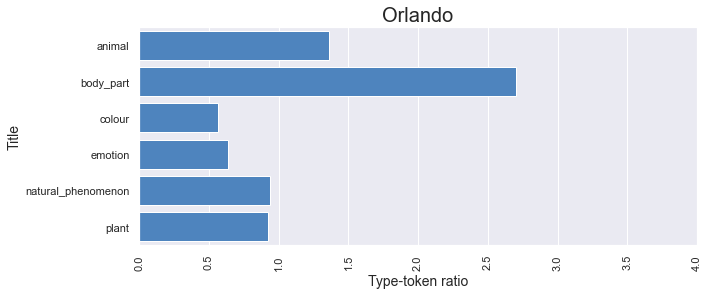



Most common emotions in "Orlando"

love (88); ecstasy (17); fear (10); happiness (10); rage (8); reverence (8); envy (8); fit (6); terror (6); joy (6); quiver (6); timidity (5); temper (5); rapture (4); excitement (4); 

Most common colours in "Orlando"

green (38); red (34); black (30); yellow (21); blue (17); purple (9); crimson (9); pink (8); brown (7); tint (6); blackness (6); scarlet (5); complexion (3); whiteness (1); blueness (1); 

Most common body_parts in "Orlando"

hand (132); eye (81); head (72); foot (50); finger (50); face (47); back (46); arm (31); cheek (27); lip (25); knee (23); ear (20); leg (19); nose (18); breast (18); 

Most common natural phenomena in "Orlando"

light (71); cloud (31); snow (30); wind (19); smoke (14); rain (13); low (13); breeze (12); weather (11); gale (11); flood (9); hail (8); puff (7); interrupt (6); mist (6); 

Most common animals in "Orlando"

horse (41); dog (36); fly (25); bird (20); bear (18); sheep (14); deer (10); female (10); goat (

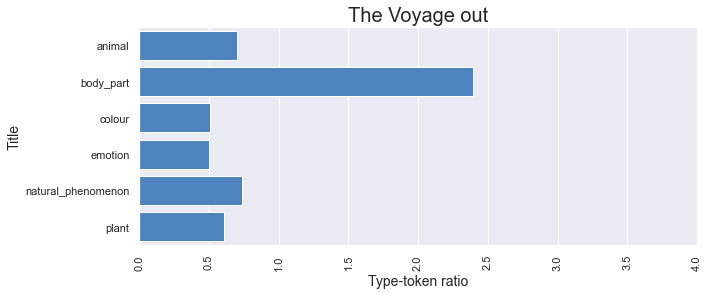



Most common emotions in "The Voyage out"

love (120); happiness (31); spite (19); hate (16); excitement (16); envy (14); fit (13); fear (9); horror (9); joy (7); anger (6); alarm (5); temper (5); thrill (5); exultation (4); 

Most common colours in "The Voyage out"

blue (59); green (55); red (53); yellow (53); black (49); brown (18); purple (13); pink (6); crimson (6); complexion (4); scarlet (2); mottle (2); amber (2); bleach (1); pallor (1); 

Most common body_parts in "The Voyage out"

eye (230); hand (186); back (166); face (143); head (128); arm (74); small (71); finger (47); foot (43); shoulder (37); lip (32); knee (29); cheek (28); leg (22); brain (20); 

Most common natural phenomena in "The Voyage out"

light (144); heat (30); wind (27); low (26); quiet (25); smoke (22); interrupt (19); mist (18); cloud (18); rain (16); storm (12); breeze (10); energy (8); weather (8); sunlight (7); 

Most common animals in "The Voyage out"

ridley (92); bird (28); fly (27); dog (24); bear 

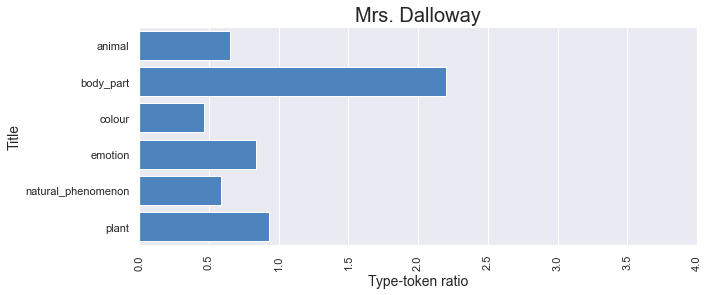



Most common emotions in "Mrs. Dalloway"

love (114); fear (18); happiness (9); hatred (8); quiver (8); horror (7); excitement (6); jealousy (6); envy (6); terror (5); spite (5); fit (5); rapture (5); rage (5); ecstasy (4); 

Most common colours in "Mrs. Dalloway"

red (28); green (26); pink (22); black (16); blue (15); yellow (14); brown (9); pallor (2); tint (2); fawn (2); crimson (1); coral (1); purple (1); blackness (1); 

Most common body_parts in "Mrs. Dalloway"

hand (113); back (87); eye (74); face (60); head (35); arm (26); finger (19); small (15); cheek (14); knee (14); lip (14); foot (13); brain (12); shoulder (12); flesh (11); 

Most common natural phenomena in "Mrs. Dalloway"

light (33); smoke (23); wind (13); bond (13); heat (13); cloud (11); interrupt (7); quiet (7); flood (6); mist (5); moonlight (5); breeze (4); pressure (4); snow (3); low (2); 

Most common animals in "Mrs. Dalloway"

dog (29); bird (18); fly (12); bear (12); mount (11); salmon (8); cricket (7); hor

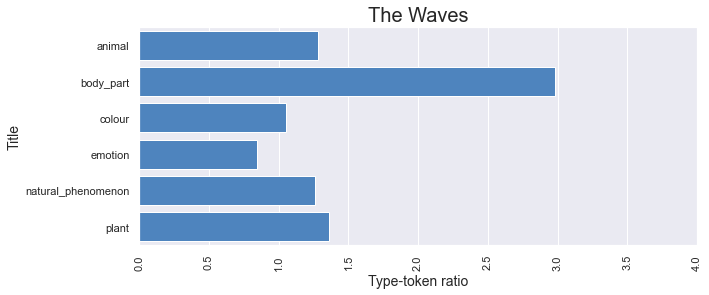



Most common emotions in "The Waves"

love (97); hate (35); quiver (22); fear (16); envy (15); happiness (13); terror (10); hatred (9); horror (9); joy (8); rapture (8); jealousy (6); rage (5); fit (5); ecstasy (5); 

Most common colours in "The Waves"

green (84); red (75); blue (58); yellow (44); black (40); purple (29); brown (18); pink (9); crimson (6); mottle (5); blackness (4); whiteness (3); coral (2); pallor (2); tint (2); 

Most common body_parts in "The Waves"

eye (132); hand (111); back (106); face (96); head (68); foot (46); finger (33); wing (31); nose (31); arm (26); lip (26); shoulder (24); small (23); ear (18); flesh (15); 

Most common natural phenomena in "The Waves"

light (146); wind (43); cloud (34); rain (19); smoke (15); heat (15); mist (11); low (10); snow (10); interrupt (9); pressure (9); breeze (8); firelight (7); gust (7); lightning (6); 

Most common animals in "The Waves"

bird (56); fly (30); horse (23); fish (19); dog (18); entire (17); cat (14); mount

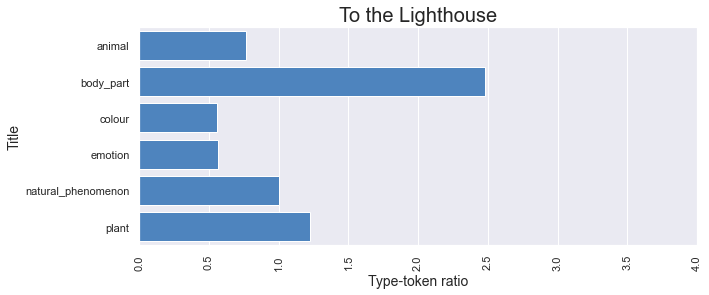



Most common emotions in "To the Lighthouse"

love (48); joy (11); happiness (9); anger (9); reverence (8); temper (7); quiver (6); rapture (6); horror (5); alarm (4); outrage (4); rage (4); uneasiness (3); shudder (3); fit (3); 

Most common colours in "To the Lighthouse"

blue (34); green (28); red (23); yellow (22); black (17); brown (16); purple (13); pink (4); pallor (3); blackness (2); bleach (2); mottle (2); complexion (1); sanguine (1); vermilion (1); 

Most common body_parts in "To the Lighthouse"

eye (119); hand (118); back (75); head (62); face (44); arm (39); foot (33); finger (25); leg (18); knee (17); lip (15); wing (14); shoulder (14); small (13); forehead (10); 

Most common natural phenomena in "To the Lighthouse"

light (86); wind (23); storm (17); smoke (15); cloud (13); low (12); breeze (11); rain (10); quiet (9); mist (8); interrupt (7); flood (7); bolt (6); pressure (6); thrust (5); 

Most common animals in "To the Lighthouse"

bird (32); bear (18); fly (16); fi

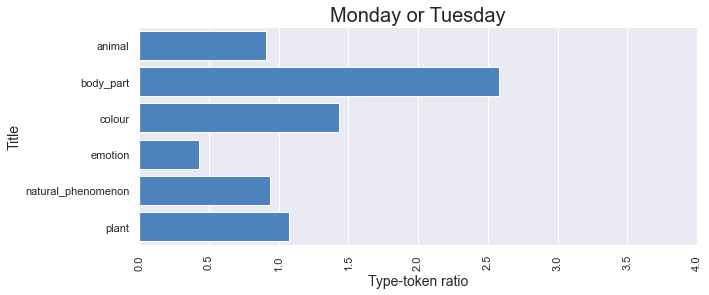



Most common emotions in "Monday or Tuesday"

love (12); joy (6); horror (3); shudder (3); quiver (1); thrill (1); alarm (1); happiness (1); spite (1); caring (1); bitterness (1); hate (1); uneasiness (1); shyness (1); rage (1); 

Most common colours in "Monday or Tuesday"

green (29); blue (25); red (22); yellow (16); black (15); brown (7); purple (4); pink (4); crimson (2); scarlet (1); blackness (1); coral (1); 

Most common body_parts in "Monday or Tuesday"

eye (31); hand (24); face (24); back (24); head (17); foot (11); finger (9); arm (8); lip (7); small (7); nail (5); shoulder (4); mouth (4); throat (3); wing (3); 

Most common natural phenomena in "Monday or Tuesday"

light (27); cloud (6); interrupt (5); smoke (5); rain (4); low (4); wind (3); storm (3); flood (2); breeze (2); heat (2); weather (2); exchange (2); moonlight (2); current (1); 

Most common animals in "Monday or Tuesday"

bear (9); fish (6); snail (6); bird (6); dragonfly (5); fly (4); butterfly (4); horse (3);

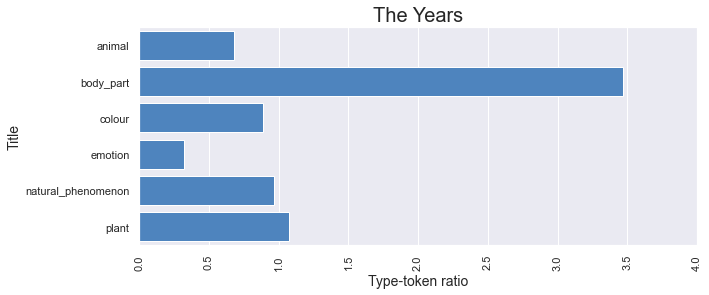



Most common emotions in "The Years"

love (64); fit (23); temper (9); excitement (9); thrill (8); envy (8); hate (7); happiness (7); alarm (6); anger (5); bitterness (5); joy (4); rapture (4); quiver (4); tingle (3); 

Most common colours in "The Years"

red (119); blue (85); yellow (83); green (75); black (54); pink (41); brown (39); purple (16); crimson (7); pallor (4); tint (3); claret (3); whiteness (3); scarlet (3); mottle (2); 

Most common body_parts in "The Years"

hand (444); back (280); eye (215); head (167); face (157); arm (82); foot (72); shoulder (58); finger (56); knee (45); nose (42); lip (35); ear (30); cheek (29); small (28); 

Most common natural phenomena in "The Years"

light (194); rain (39); interrupt (39); smoke (32); cloud (31); wind (29); snow (28); low (27); quiet (19); mist (19); gust (12); puff (11); breeze (10); ray (10); moonlight (8); 

Most common animals in "The Years"

horse (50); dog (47); bird (35); fly (23); fish (17); pigeon (15); cat (14); shee

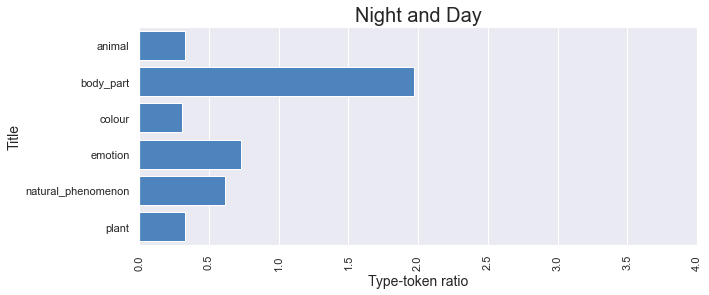



Most common emotions in "Night and Day"

love (215); happiness (32); spite (31); fit (23); anger (22); temper (17); fear (17); alarm (15); exaltation (15); excitement (11); envy (10); nervousness (8); bitterness (8); quiver (7); hate (7); 

Most common colours in "Night and Day"

blue (47); green (38); red (29); yellow (24); black (22); brown (14); gray (14); purple (13); pink (11); crimson (9); scarlet (6); tint (4); pallor (4); amber (1); complexion (1); 

Most common body_parts in "Night and Day"

eye (236); hand (222); back (178); head (169); face (150); arm (50); finger (47); foot (43); small (41); lip (41); shoulder (25); ear (23); cheek (22); brain (19); knee (19); 

Most common natural phenomena in "Night and Day"

light (164); interrupt (36); low (32); wind (26); quiet (18); mist (16); smoke (13); cloud (11); current (9); fog (8); radiance (7); gravity (6); torrent (6); weather (6); energy (6); 

Most common animals in "Night and Day"

bird (27); bear (23); fly (16); dog (13

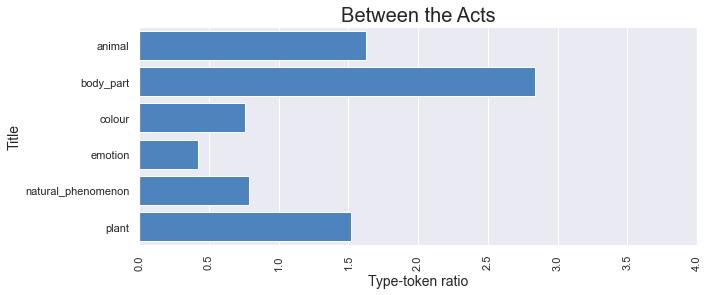



Most common emotions in "Between the Acts"

love (42); hate (8); fear (6); fit (5); rage (5); joy (3); horror (3); quiver (2); shudder (2); spite (2); envy (2); outrage (2); anger (2); rapture (2); fury (1); 

Most common colours in "Between the Acts"

green (39); red (34); yellow (29); blue (28); black (24); pink (6); brown (6); purple (4); azure (2); amber (1); crimson (1); scarlet (1); whiteness (1); aqua (1); ebony (1); 

Most common body_parts in "Between the Acts"

hand (97); eye (69); head (52); face (45); back (36); arm (32); finger (30); foot (27); nose (15); lip (14); shoulder (14); knee (13); ear (13); leg (13); cheek (13); 

Most common natural phenomena in "Between the Acts"

light (33); wind (18); breeze (17); cloud (13); rain (12); weather (10); low (9); smoke (9); interrupt (8); hail (7); thrust (6); drag (4); heat (3); fog (3); bond (3); 

Most common animals in "Between the Acts"

dog (33); cow (29); bird (26); fish (26); spaniel (26); horse (20); butterfly (17); ca

In [16]:
for file in os.listdir(directory):
    
    if re.search( 'lemma.txt',file ):
        data = []
        
        key = os.path.join(directory,re.sub('_lemma','',file))
        title = titles[key]
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            words = clean_wordlist(words)
            freq = Counter(words)

            for word,count in freq.most_common():
                hypernyms = wordnet_hypernyms(word)
                if len(hypernyms)>0:
                    for h in hypernyms:
                        row = []
                        row.append(word)
                        row.append(h)
                        row.append(count)
                        data.append(row)
                        
        df = pd.DataFrame(data,columns=['word','domain','count'])
                        
                        

        x_axis = list(df.groupby('domain')['count'].sum().to_dict().values())
        # normalise values
        x_axis = [(value/nr_tokens[key])*100 for value in x_axis]
        y_axis = list(df.groupby('domain')['count'].sum().to_dict().keys())
                                
        colours = ['#599ad3','#f9a65a']

        fig = plt.figure( figsize=( 10,4 ) )

        graph = sns.barplot( x=x_axis, y=y_axis, 
                            color = '#3b83d1' )

        graph.set_title(title , size = 20) 
        graph.set_xlabel('Type-token ratio' , size = 14) 
        graph.set_ylabel('Title' , size = 14 )
        
        graph.set_xlim(0,4)


        plt.xticks(rotation= 90)

        plt.show()
        
        print(f'\n\nMost common emotions in "{titles[key]}"\n')
        
        count = 0
        for i,row in df.query(' domain=="emotion" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                
        print(f'\n\nMost common colours in "{titles[key]}"\n')
        
        count = 0
        for i,row in df.query(' domain=="colour" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common body_parts in "{titles[key]}"\n')
        
        count = 0
        for i,row in df.query(' domain=="body_part" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        
        print(f'\n\nMost common natural phenomena in "{titles[key]}"\n')
        
        count = 0
        for i,row in df.query(' domain=="natural_phenomenon" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common animals in "{titles[key]}"\n')
        
        count = 0
        for i,row in df.query(' domain=="animal" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                

# Unique adjectives, adverbs and nouns per novel

In [17]:
all_novels = list(all_verbs.keys())
for text in all_novels:
    print(f'\n\n"{titles[text]}"\n')
    other_novels = all_novels
    other_novels.remove(text)
    adj_adv_other_novels = []
    for other in other_novels:
        adj_adv_other_novels.extend(list(set(all_adj_adv_noun[other])))
        
    freq = Counter(all_adj_adv_noun[text])
    for word in freq.keys():
        if word in adj_adv_other_novels:
            freq[word]=0
            
    for  word,count in freq.most_common(30):
        print(word,count)
    



"Monday or Tuesday"

castalia 19
moggridge 13
poll 10
whitaker 6
hobkin 5
flower-bed 4
oxbridge 3
president 3
kruger 3
aspidistra 3
marshes 3
precedency 3
chancellors 2
academy 2
cactus 2
unchastity 2
cassy 2
unworldly 2
cultivate 2
ferns 2
poulterer 2
shop-window 2
cheaper 2
foothold 2
heart-shaped 2
tongue-shaped 2
insulate 2
uruguay 2
bert 2
damnation 2


"To the Lighthouse"

ramsay 337
minta 72
cam 63
tansley 59
carmichael 41
briscoe 40
macalister 25
jasper 19
rayley 16
ramsays 15
mcnab 14
doyle 10
easel 9
beckwith 8
rayleys 7
boeuf 5
en 5
daube 5
bast 5
disparage 4
hume 4
hive 4
kennedy 4
luriana 4
lurilee 4
earwig 4
swiss 3
shag 3
dune 3
paunceforte 3


"The Waves"

louis 135
jinny 121
rhoda 107
percival 89
currant 10
crane 10
lambert 9
nile 8
fin 8
cheep 7
elvedon 7
brisbane 7
australian 7
sequence 7
archie 7
tram 7
drum 6
shop-windows 6
moffat 6
peeling 6
wilt 6
sediment 5
swing-door 4
immitigable 4
sea-holly 4
boasting 4
tripper 4
serge 4
dalton 4
compulsion 4


"The Years"


# Unique verbs per novel

In [18]:
all_novels = list(all_verbs.keys())

for text in all_novels:
    print(f'\n\n"{titles[text]}"\n')
    other_novels = all_novels
    other_novels.remove(text)
    
    verbs_other_novels = []
    for other in other_novels:
        verbs_other_novels.extend(list(set(all_verbs[other])))
        
    freq = Counter(all_verbs[text])
    for word in freq.keys():
        if word in verbs_other_novels:
            freq[word]=0
            
    for word,count in freq.most_common(30):
        print(word,count)
    



"Monday or Tuesday"

stooping 2
thresh 1
wandering 1
vain 1
poetry 1
venerate 1
discovering 1
addict 1
asking 1
answering 1
safeguard 1
bracket 1
inconclusive 1
intellect 1
flaunted 1
fallen 1
discount 1
staying 1
spasm 1
stiffly 1
faithful 1
passing 1
violet 1
spangle 1
overnight 1
preachers 1
glimpse 1
sir 1
drawer 1
sea 1


"To the Lighthouse"

ramsay 7
hypnotise 4
simpler 3
lighthouse 3
beauty 2
flaw 2
snuffle 2
had 2
ladle 2
smite 2
mildred 2
scythe 2
harmonise 2
dawdle 2
fabled 1
chivalry 1
negotiate 1
infidel 1
wilder 1
disappearing 1
elucidate 1
insinuating 1
gown 1
craning 1
uninhabited 1
parody 1
task 1
commune 1
straddle 1
wild 1


"The Waves"

glut 5
speck 4
vast 3
troop 3
blue 3
door 3
pirouette 3
rippling 3
film 3
spear 3
blister 3
fuse 2
unseeing 2
rot 2
rollick 2
shiny 2
fertilize 2
bee 2
integrate 2
foam 2
louis 2
fledge 2
many-sided 2
penance 2
ripen 2
abrade 2
squeal 2
immerse 2
mainspring 2
hairy 2


"The Years"

rose 8
damned 5
free 5
hot 4
volley 4
coo 4
haul 4


## Sentiment analysis

The cells below identifies the sentences with the highest and the lowest sentiment scores in all the novels. 

In [19]:
all_novels = list(all_verbs.keys())

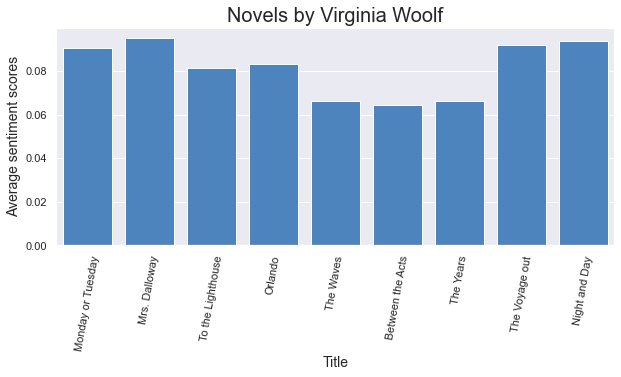

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

ana = SentimentIntensityAnalyzer()

def average_score(file):
    all_scores = []
    file = open( file , encoding = 'utf-8' )
    full_text = file.read()
    sentences = sent_tokenize( full_text )
    for s in sentences:
        scores = ana.polarity_scores(s)
        all_scores.append( scores["pos"] )
    return sum(all_scores)/len(all_scores)
        
sent_scores = dict()

for novel in all_novels:

    avg_score = average_score(novel)
    sent_scores[novel]=avg_score
    

    
x_axis = list(sent_scores.keys())
y_axis = list(sent_scores.values())

x_axis = [titles[novel] for novel in x_axis]

fig = plt.figure( figsize=( 10,4 ) )

graph = sns.barplot( x=x_axis, y=y_axis, 
                    color = '#3b83d1' )

graph.set_title( 'Novels by Virginia Woolf' , size = 20) 
graph.set_xlabel('Title' , size = 14 )
graph.set_ylabel('Average sentiment scores' , size = 14) 


plt.xticks(rotation= 80)

plt.show()

In [21]:

def sortedByValue( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}

sent_scores = dict()

for novel in all_novels:
    
    title = titles[novel]
    print(f"\"{title}\"")

    file = open(novel , encoding = 'utf-8')
    full_text = file.read()
    sentences = sent_tokenize(full_text)

    for s in sentences:
        s = re.sub(r'\s+',' ',s)
        scores = ana.polarity_scores(s)
        sent_scores[s] = scores['compound']

    nr_sentences = 5
    
    print(f'\nPostive sentences in \"{title}\"\n')

    i = 0
    for s in sortedByValue( sent_scores , ascending = False ):
        print( f'{s} [{ sent_scores[s]}]' )
        i+= 1
        if i == nr_sentences:
            break

    print(f'\nNegative sentences in \"{title}\"\n')
    i = 0
    for s in sortedByValue( sent_scores , ascending = True):
        print( f'{s} [{ sent_scores[s]}]' )
        i+= 1
        if i == nr_sentences:
            break

"Monday or Tuesday"

Postive sentences in "Monday or Tuesday"

Retired Colonels for the most part, I daresay, leading parties of aged labourers to the top here, examining clods of earth and stone, and getting into correspondence with the neighbouring clergy, which, being opened at breakfast time, gives them a feeling of importance, and the comparison of arrow-heads necessitates cross-country journeys to the county towns, an agreeable necessity both to them and to their elderly wives, who wish to make plum jam or to clean out the study, and have every reason for keeping that great question of the camp or the tomb in perpetual suspension, while the Colonel himself feels agreeably philosophic in accumulating evidence on both sides of the question. [0.9657]
After a time, so far as I can remember, we drew round the fire and began as usual to praise men--how strong, how noble, how brilliant, how courageous, how beautiful they were--how we envied those who by hook or by crook managed to get a


Postive sentences in "Orlando"

Not indeed in actual words; that is, he could not read the language yet; but it was plain enough, this beauty, this exquisite beauty, and tears filled his eyes as he looked at the smoke words languishing and melting in the sky and bestowing upon him in their inexhaustible charity and laughing goodness one shape after another of unimaginable beauty and signalling their intention to provide him, for nothing, for ever, for looking merely, with beauty, more beauty! [0.992]
He could not keep out of smoking-rooms, liked colonels, liked golf, liked bridge, and above all women's society, and the fineness of their companionship, and their faithfulness and audacity and greatness in loving which though it had its drawbacks seemed to him (and the dark, adorably pretty face was on top of the envelopes) so wholly admirable, so splendid a flower to grow on the crest of human life, and yet he could not come up to the scratch, being always apt to see round things (Clari


Postive sentences in "Between the Acts"

Not indeed in actual words; that is, he could not read the language yet; but it was plain enough, this beauty, this exquisite beauty, and tears filled his eyes as he looked at the smoke words languishing and melting in the sky and bestowing upon him in their inexhaustible charity and laughing goodness one shape after another of unimaginable beauty and signalling their intention to provide him, for nothing, for ever, for looking merely, with beauty, more beauty! [0.992]
He could not keep out of smoking-rooms, liked colonels, liked golf, liked bridge, and above all women's society, and the fineness of their companionship, and their faithfulness and audacity and greatness in loving which though it had its drawbacks seemed to him (and the dark, adorably pretty face was on top of the envelopes) so wholly admirable, so splendid a flower to grow on the crest of human life, and yet he could not come up to the scratch, being always apt to see round thin


Postive sentences in "The Voyage out"

Not indeed in actual words; that is, he could not read the language yet; but it was plain enough, this beauty, this exquisite beauty, and tears filled his eyes as he looked at the smoke words languishing and melting in the sky and bestowing upon him in their inexhaustible charity and laughing goodness one shape after another of unimaginable beauty and signalling their intention to provide him, for nothing, for ever, for looking merely, with beauty, more beauty! [0.992]
He could not keep out of smoking-rooms, liked colonels, liked golf, liked bridge, and above all women's society, and the fineness of their companionship, and their faithfulness and audacity and greatness in loving which though it had its drawbacks seemed to him (and the dark, adorably pretty face was on top of the envelopes) so wholly admirable, so splendid a flower to grow on the crest of human life, and yet he could not come up to the scratch, being always apt to see round things

## Named Entity Recognition

In [ ]:
data = []
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

for file in corpus:
    item = dict()
    item['title'] = titles[file]
    print(file)
    entities = dict()
    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    for sentence in sentences:
        doc=nlp(sentence)
        for ent in doc.ents:
            entities[ent.text] = ent.type
    item['entities'] = entities
    data.append(item)
    


In [ ]:
json_object = json.dumps(data, indent = 4) 
with open(os.path.join(directory,'woolf_ner.json'),'w',encoding='utf-8') as out:
    out.write(json_object) 

In [24]:


json_file = open(os.path.join(directory,'woolf_ner.json'))
ner = json.load(json_file)

for novel in all_novels:
    print(f"\n\n\"{titles[novel]}\"\n")
    for text in ner:
        if text['title'] == titles[novel]:
            data = text['entities']
            df = pd.DataFrame(data.items(),columns=['word','type'])
            
            print('Most frequent works of art')
            freq = Counter( df.query('type=="WORK_OF_ART"')['word'] )
            for word,count in freq.most_common(10):
                word = re.sub(r'\s+',' ',word)
                print('\t'+word)
                
            print('\nMost frequent locations:')
            freq = Counter( df.query('type=="GPE"')['word'] )
            for word,count in freq.most_common(10):
                word = re.sub(r'\s+',' ',word)
                print('\t'+word)
                
            print('\nMost frequent organisations:')
            freq = Counter( df.query('type=="ORG"')['word'] )
            for word,count in freq.most_common(10):
                word = re.sub(r'\s+',' ',word)
                print('\t'+word)
                
            
            freq = Counter( df.query('type=="EVENT"')['word'] )
            if len(freq)>0:
                print('\nMost frequent events:')
                for word,count in freq.most_common(10):
                    word = re.sub(r'\s+',' ',word)
                    print('\t'+word)
                




"Monday or Tuesday"

Most frequent works of art
	From a Window"
	"In a Garden
	the Lives of the Lord Chancellors
	the Evening News
	Truth
	The Mark on the Wall
	Whitaker's Table of Precedency

Most frequent locations:
	Oxford
	Cambridge
	England
	Dulwich
	the City
	India
	Ireland
	Kensington
	Brighton
	Lahore

Most frequent organisations:
	Times
	the Royal Academy
	the Law Courts
	the British Navy
	Oxbridge
	the Stock Exchange
	a Government Office
	the British Empire
	the House of Commons
	the London Library

Most frequent events:
	the Allied Powers


"Mrs. Dalloway"

Most frequent works of art
	Big Ben
	Whitbreads
	Jorrocks' Jaunts and Jollities
	Big Game Shooting
	Star-gazing
	the Morning Post
	The History of Civilisation
	Inferno
	the Unknown Warrior
	Lords

Most frequent locations:
	India
	Westminster
	London
	Ascot
	Bath
	Nigeria
	England
	Italy
	Hurlingham
	China

Most frequent organisations:
	Parliament
	Embassy
	Government
	the Royal Arms
	Court
	Pimlico
	Fleet
	Admiralty
	Pi